In [4]:
from pydub import AudioSegment

In [5]:
audio = AudioSegment.from_file("song.mp3")


In [7]:
print("Duration of audio file:", len(audio))
print("Channels:",audio.channels)
print("Frame Rate:",audio.frame_rate)
print("Sample Width :" , audio.sample_width)
print("dBFS (average loudness):",audio.dBFS)

Duration of audio file: 321025
Channels: 2
Frame Rate: 48000
Sample Width : 2
dBFS (average loudness): -16.744095660653517


In [8]:
first_5_sec = audio[:5000]
next_5_sec = audio[5000:10000]

In [9]:
fade_in = first_5_sec.fade_in(3000)
fade_out = next_5_sec.fade_out(3000)

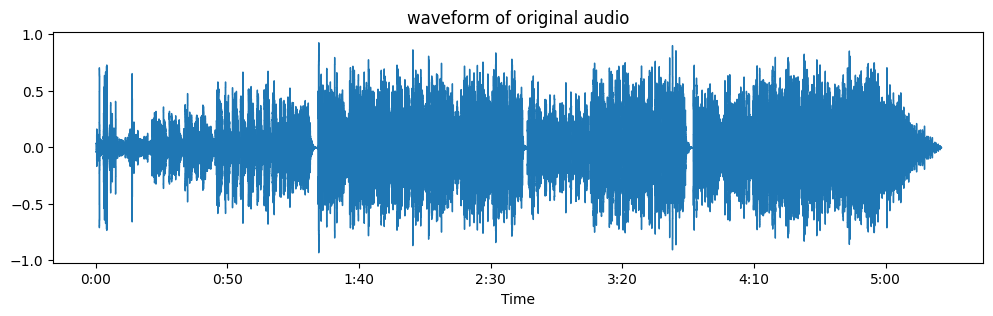

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y , sr = librosa.load("song.mp3")
plt.figure(figsize=(12,3))
librosa.display.waveshow(y,sr=sr)
plt.title("waveform of original audio")
plt.show()

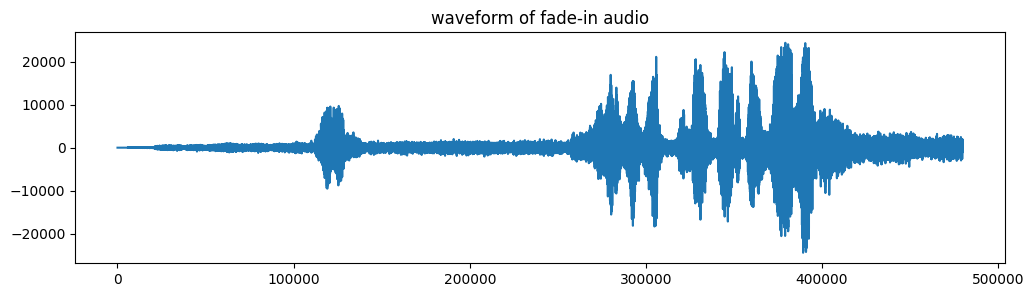

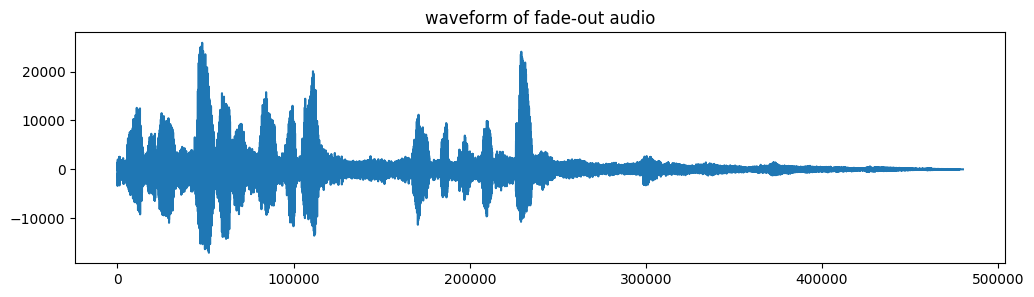

In [11]:
fade_in_audio = fade_in.get_array_of_samples()
fade_out_audio = fade_out.get_array_of_samples()

plt.figure(figsize=(12,3))
plt.plot(fade_in_audio)
plt.title("waveform of fade-in audio")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(fade_out_audio)
plt.title("waveform of fade-out audio")
plt.show()

In [12]:
from pydub import AudioSegment
import os, random

In [ ]:
import os
import random
from pydub import AudioSegment

def smooth_fade_mixtape(folder, output="output_mixtape.mp3", transition_ms=6000):
    
    files = [f for f in os.listdir(folder) if f.endswith((".mp3", ".wav"))]
    
    if not files:
        print("No audio files found in folder.")
        return
    
    random.shuffle(files)
    all_songs = None

    for i, file in enumerate(files):
        song_path = os.path.join(folder, file)
        song = AudioSegment.from_file(song_path)
        
        # Standardize format
        song = song.set_channels(2).set_frame_rate(44100)


        if all_songs is None:
            all_songs = song
        else:
            # define overlap region
            overlap = min(transition_ms, len(song), len(all_songs))

            # outgoing section (end of current mix)
            outgoing = all_songs[-overlap:].fade_out(overlap).low_pass_filter(4000)

            # incoming section (start of next song)
            incoming = song[:overlap].fade_in(overlap).low_pass_filter(4000)

            # create transition
            transition = outgoing.overlay(incoming)

            # merge everything
            all_songs = all_songs[:-overlap] + transition + song[overlap:]

    # Export only once after loop
    all_songs.export(output, format="mp3")
    print(f"Smooth fade mixtape generated: {output}")


# Call function (OUTSIDE the function)
smooth_fade_mixtape("all_songs")


Smooth fade mixtape generated: output_mixtape.mp3


In [17]:
import os
from pydub import AudioSegment
from datetime import timedelta

def format_timestamp(milliseconds):
    seconds = milliseconds // 1000
    return str(timedelta(seconds=seconds))[2:7] if seconds < 3600 else str(timedelta(seconds=seconds))

def generate_youtube_description(folder, artist_name="Amani", output_file="youtube_description.txt"):
    
    files = [f for f in os.listdir(folder) if f.endswith((".mp3", ".wav"))]
    
    if not files:
        print("No audio files found.")
        return

    files.sort()  # Keep original order (remove if you want random)

    description = []
    description.append(f"🎧 {artist_name} Mixtape")
    description.append("")
    description.append("🔥 Smooth transitions | Chill vibes | Perfect mix")
    description.append("")
    description.append("⏱️ Tracklist:")
    description.append("")

    current_time = 0
    total_duration = 0

    for file in files:
        song_path = os.path.join(folder, file)
        audio = AudioSegment.from_file(song_path)
        
        duration = len(audio)
        timestamp = format_timestamp(current_time)

        # Clean song name (remove extension)
        song_name = os.path.splitext(file)[0]

        description.append(f"{timestamp} - {song_name}")

        current_time += duration
        total_duration += duration

    total_time_formatted = format_timestamp(total_duration)

    description.append("")
    description.append(f"⏳ Total Mix Duration: {total_time_formatted}")
    description.append("")
    description.append("💬 Comment your favorite track!")
    description.append("👍 Like | 🔔 Subscribe | 🔁 Share")
    description.append("")
    description.append("📌 Follow Amani for more mixes!")
    description.append("")
    description.append("#Amani #AmaniMix #ChillVibes #SmoothMix #Mixtape #DJMix #MusicLovers")

    final_description = "\n".join(description)

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(final_description)

    print("YouTube description generated successfully!")
    print("\n")
    print(final_description)


# Example usage
generate_youtube_description("all_songs", artist_name="Amani")


YouTube description generated successfully!


🎧 Amani Mixtape

🔥 Smooth transitions | Chill vibes | Perfect mix

⏱️ Tracklist:

00:00 - song1
04:54 - song2

⏳ Total Mix Duration: 09:06

💬 Comment your favorite track!
👍 Like | 🔔 Subscribe | 🔁 Share

📌 Follow Amani for more mixes!

#Amani #AmaniMix #ChillVibes #SmoothMix #Mixtape #DJMix #MusicLovers


In [18]:
import subprocess
import os 
from PIL import Image

In [6]:
import os
import subprocess
from PIL import Image

def make_video_from_audio(
    image_path,
    audio_path,
    output_path="final_mixtape_video.mp4",
    resolution=(1280, 720)
):

    print("Working Directory:", os.getcwd())
    print("Files in this folder:", os.listdir())

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio not found: {audio_path}")

    # Resize image
    img = Image.open(image_path)
    img = img.resize(resolution)
    img.save("temp_image.jpg")

    cmd = [
        "ffmpeg",
        "-y",
        "-loop", "1",
        "-i", "temp_image.jpg",
        "-i", audio_path,
        "-c:v", "libx264",
        "-tune", "stillimage",
        "-c:a", "aac",
        "-b:a", "192k",
        "-shortest",
        "-pix_fmt", "yuv420p",
        "-movflags", "+faststart",
        output_path
    ]

    subprocess.run(cmd)
    os.remove("temp_image.jpg")

    print("✅ Video created:", output_path)


# -------- CALL --------
image_path = "images/image.png"
audio_path = "output_mixtape.mp3"

make_video_from_audio(image_path, audio_path)


Working Directory: c:\Users\gadda\OneDrive\Desktop\projects\youtube_mixtape\experiment_notebooks
Files in this folder: ['all_songs', 'experiment.ipynb', 'images', 'output', 'output_mixtape.mp3', 'youtube_description.txt']
✅ Video created: final_mixtape_video.mp4
